# Convolutional Neural Networks (CNNs)

### HW2 @ DL Course, Dr. Soleymani

*Full Name:* Mehdi Jamalkhah

*SID:* ...

In this homework, you will work with [Google colab](https://colab.research.google.com/). Google colab allows you to run a jupyter notebook on Google servers using a GPU/TPU. To enable GPU support, make sure to press `Runtime -> Change Runtime Type -> GPU`. 

## Task: Cats vs Dogs

To learn about CNNs we will be working on a problem of great importance in computer vision, **classifying images of cats and dogs** :)

The problem is so important that there's even an easter egg in colab: go to `Tools -> Settings -> Miscellaneous and enable 'Kitty mode' and 'Corgi mode'` to get more cats and dogs to classify when you're tired of coding :)

### Getting the data

To get started with the classification, we first need to download and unpack the dataset (note that in jupyter notebooks commands starting with `!` are executed in bash, not in python):

In [12]:
! wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O ./data/cats_and_dogs_filtered.zip

--2024-08-14 21:53:48--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.213.123, 216.58.212.27, 142.250.187.155, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.213.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘./data/cats_and_dogs_filtered.zip’

./data/cats_and_dog 100%[===================>]  65.43M  1.55MB/s    in 34s     

2024-08-14 21:54:23 (1.94 MB/s) - ‘./data/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [13]:
! unzip ./data/cats_and_dogs_filtered

Archive:  ./data/cats_and_dogs_filtered.zip
   creating: cats_and_dogs_filtered/
  inflating: cats_and_dogs_filtered/vectorize.py  
   creating: cats_and_dogs_filtered/validation/
   creating: cats_and_dogs_filtered/train/
   creating: cats_and_dogs_filtered/validation/dogs/
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2126.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2125.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2124.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2123.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2122.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2121.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2120.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2119.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2118.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/do

### Dataset Organization
Our dataset contains two directories, `train` and `validation`, both containing two directories with images: `cats` and `dogs`. In `train` we have 1000 images of cats and 1000 images of dogs. For `validation`, we have 500 images of each class. Our goal is to implement and train a CNN to classify these images, i.e. given an image from this dataset, tell if it contains a *cat* or a *dog*.

```bash
├── dir.txt
├── train
│   ├── cats
│   │   ├── cat.0.jpg
│   │   ├── cat....jpg
│   │   ├── cat.999.jpg
│   └── dogs
│       ├── dog.0.jpg
│       ├── dog....jpg
│       ├── dog.999.jpg
├── validation
│   ├── cats
│   │   ├── cat.2000.jpg
│   │   ├── cat....jpg
│   │   └── cat.2499.jpg
│   └── dogs
│       ├── dog.2000.jpg
│       ├── dog....jpg
│       └── dog.2499.jpg
└── vectorize.py

6 directories, 3002 files
```

### Loading the data
 Now that we have the data on our disk, we need to load it so that we can use it to train our model. In Pytorch, we use `Dataset` class, documentation for which can be found [here](https://pytorch.org/docs/stable/data.html). 

 Torchvision is a Pytorch library with many commonly used tools in computer vision. In the case of computer vision, the datasets with the folder structure `label_name/image_file` are very common, and to process those there's already an implemented class `torchvision.datasets.ImageFolder` (documented [here](https://pytorch.org/vision/0.8/datasets.html)). 

 Another thing we need from Torchvision library is [transforms](https://pytorch.org/docs/stable/torchvision/transforms.html). In computer vision, we very often want to transform the images in certain ways. The most common is **normalization**. Others include *flipping*, changing *saturation*, *hue*, *contrast*, *rotation*, and *blurring*. 

 Below, we create training, validation and test sets. We use a few transforms for **augmentation** on the training set, but we don't use anything but **resize** and **normalization** for validation and test. 

In [1]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image

# These numbers are mean and std values for channels of natural images. 
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

# Inverse transformation which is needed for plotting.
inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

train_transforms = transforms.Compose([
                                    transforms.Resize((256, 256)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ColorJitter(hue=.1, saturation=.1, contrast=.1),
                                    transforms.RandomRotation(20, interpolation=Image.Resampling.BILINEAR),
                                    transforms.GaussianBlur(7, sigma=(0.1, 1.0)),
                                    transforms.ToTensor(), # This is necessary to convert PIL to torch Tensor
                                    normalize,
                                ])

validation_transforms = transforms.Compose([
                                    transforms.Resize((256, 256)),
                                    transforms.ToTensor(), 
                                    normalize,
                                ])

train_dataset = torchvision.datasets.ImageFolder('./data/cats_and_dogs_filtered/train', transform=train_transforms)
test_dataset = torchvision.datasets.ImageFolder('./data/cats_and_dogs_filtered/validation', transform=validation_transforms)

validation_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [500, 500], generator=torch.Generator().manual_seed(42))

### Dataset Inspection
Let's see what one of the images in the dataset looks like (you can run this cell multiple times to see the effects of different augmentations):

torch.Size([3, 256, 256])


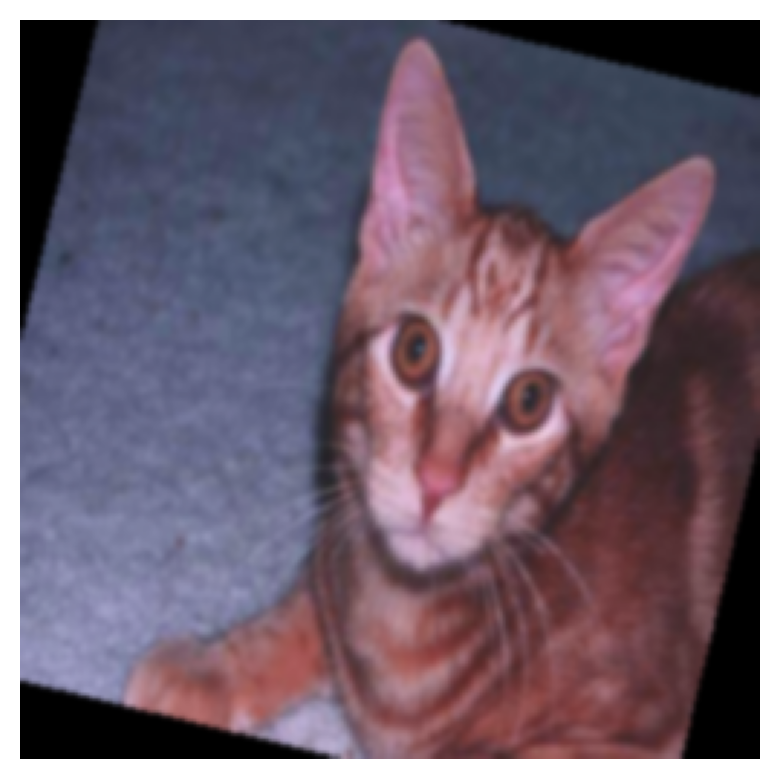

In [2]:
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 200 # change dpi to make plots bigger

def show_normalized_image(img, title=None):
    plt.imshow(inv_normalize(img).detach().cpu().permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')

print(train_dataset[10][0].shape)
show_normalized_image(train_dataset[10][0])

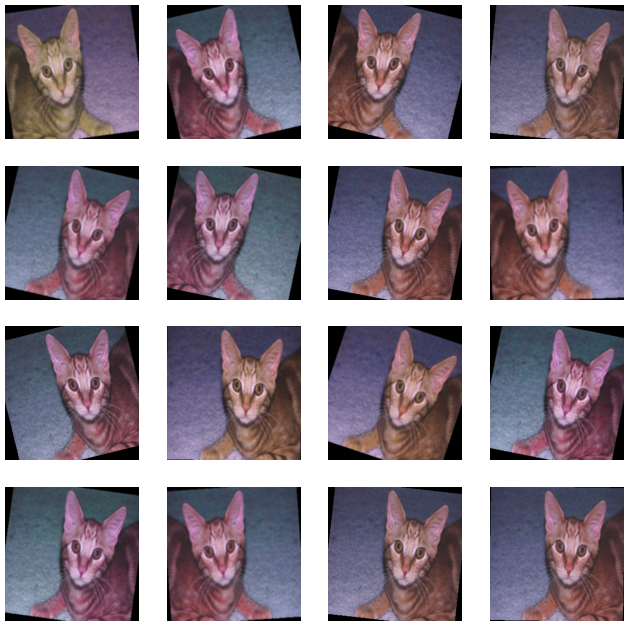

In [3]:
# checking the augmentation
plt.rcParams['figure.dpi'] = 50
plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4, 4, i+1)
    show_normalized_image(train_dataset[10][0])
plt.show()

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Creating the model

Now is the time to create a model. 

All models in Pytorch are subclassing `torch.nn.Module`. We have to implement `__init__` and `forward` methods. 

Below we provide a simple model skeleton, which you need to expand. The places to put your code are marked with `TODO`. Here, we ask you to implement a CNN containing the following elements:

* Convolutional layers (at least two)
* Pooling layers
* Non-linearity
* Residual connections similar to that of **ResNet**
* fully connected layer(s)

Note that you cannot use Batch Normalization layers in this step.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
        self.identity_downsample = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        identity = self.identity_downsample(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        
        return x + identity
        

class CNN_cat_dog(torch.nn.Module):

    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.block1 = ConvBlock(64, 128)
        self.block2 = ConvBlock(128, 256)
        
        self.avgPool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(256, num_classes)

    def forward(self, x):   
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.block1(x)
        x = self.block2(x)
        
        x = self.avgPool(x)
        x = self.fc1(x)
        
        return x

In [7]:
model = CNN_cat_dog(3, 2)
model.to(device)

CNN_cat_dog(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (block1): ConvBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
    (identity_downsample): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (block2): ConvBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
    (identity_downsample): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (avgPool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=256, out_features=2, bias=True)
)

### Training the model

Now we train the model on the dataset. Again, we're providing you with the skeleton with some parts marked as `TODO` to be filled by you.

In [ ]:
from tqdm.notebook import tqdm
import torch.optim as optim

def get_loss_and_correct(model, batch, labels, criterion, device, test_mode=False):
    """
    Implement forward pass and loss calculation for one batch.
    
    Return a tuple:
    - loss for the batch (Tensor)
    - number of correctly classified examples in the batch (Tensor)
    """
    
    batch, labels = batch.to(device), labels.to(device)
    output = model(batch)
    loss = criterion(output, labels)
    
    _, predicted = output.max(1)
    correct_indecis = predicted.eq(labels)
    corrects = correct_indecis.sum().item()
    
    if test_mode:
        correct_images = [(img, label) for img, label in zip(batch[correct_indecis], labels[correct_indecis])]
        incorrect_images = [(img, true_label, pred_label) for img, true_label, pred_label in zip(batch[~correct_indecis],
                                                                                             labels[~correct_indecis],
                                                                                             predicted[~correct_indecis])]
    if test_mode:
        return loss, corrects, correct_images, incorrect_images
    
    return loss, corrects
    
    


def step(loss, optimizer):
    """
    Implement backward pass and update.
    """
    loss.backward()
    optimizer.step()

In [ ]:
N_EPOCHS = 10
BATCH_SIZE = 128

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, num_workers=4)
model = CNN_cat_dog(3, 2)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

model.train()

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

history = {'train_losses': [], 'train_accuracies': [], 'validation_losses': [], 'validation_accuracies': []}

pbar = tqdm(range(N_EPOCHS))

for i in pbar:
    total_train_loss = 0.0
    total_train_correct = 0.0
    total_validation_loss = 0.0
    total_validation_correct = 0.0

    model.train()

    for batch, labels in tqdm(train_dataloader, leave=False):
        train_loss, train_correct = get_loss_and_correct(model, batch, labels, criterion, device)
        step(train_loss, optimizer)
        
        total_train_loss += train_loss
        total_train_correct += train_correct

    with torch.no_grad():
        for batch, labels in validation_dataloader:
            val_loss, val_correct = get_loss_and_correct(model, batch, labels, criterion, device)

    mean_train_loss = total_train_loss / len(train_dataloader)
    train_accuracy = total_train_correct / len(train_dataset)

    mean_validation_loss = total_validation_loss / len(validation_dataloader)
    validation_accuracy = total_validation_correct / len(validation_dataset)

    history['train_losses'].append(mean_train_loss)
    history['validation_losses'].append(mean_validation_loss)

    history['train_accuracies'].append(train_accuracy)
    history['validation_accuracies'].append(validation_accuracy)

    pbar.set_postfix({'train_loss': mean_train_loss, 'validation_loss': mean_validation_loss, 'train_accuracy': train_accuracy, 'validation_accuracy': validation_accuracy})

Now that the model is trained, we want to visualize the training and validation losses and accuracies:

In [ ]:
plt.figure(dpi=200, figsize=(10, 5))

plt.subplot(121)
plt.plot(history['train_losses'], label='train')
plt.plot(history['validation_losses'], label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Losses')
plt.legend()

plt.subplot(122)
plt.plot(history['train_accuracies'], label='train')
plt.plot(history['validation_accuracies'], label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.title('Accuracies')

plt.tight_layout()
plt.show()

Now, change your model to achieve at least 75% accuracy on validation set. Add Dropout and Batch Norm layers where needed. You can change the model you've implemented (including the model depth, activation functions, etc.), the optimizer (including the regularizer terms), and the augmentations. 

#### Question
Looking at the loss and accuracy plots, can you see if your model overfits the trainig set? Why?


### Testing the model

Now, use the `test_dataset` to get the final accuracy of your model. Visualize some correctly and incorrectly classified examples.

In [ ]:
# TODO
# 1. Calculate and show the test_dataset accuracy of your model.
# 2. Visualize some correctly and incorrectly classified examples.
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
with torch.no_grad():
    model.eval()
    total_test_correct = 0
    total_correct_images = []
    total_incorrect_images = []
    for batch, labels in test_dataloader:
        test_loss, test_correct, correct_images, incorrect_images = get_loss_and_correct(model, batch, labels, criterion, device)
        total_test_correct += test_correct
        total_correct_images.append(correct_images)
        total_incorrect_images.append(incorrect_images)
        
    test_accuracy = total_test_correct / len(test_dataset)
print(f"Test accuracy: {test_accuracy}")

### Visualizing filters

In this part, we are going to visualize the output of one of the convolutional layers to see what features they focus on.

First, let's get some image.

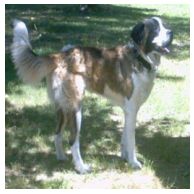

In [5]:
image = validation_dataset[10][0]
show_normalized_image(image)

Now, we are going to *clip* our model at different points to get different intermediate representation. 
* Clip your model at two or three different points and plot the filters output.

In order to clip the model, you can use `model.children()` method. For example, to get output only after the first 4 layers, you can do:

```
clipped = nn.Sequential(
    *list(model.children()[:2])
)
intermediate_output = clipped(input)
```



In [ ]:
# generate the intermediate output and print its shape
# TODO

In [ ]:
import math

def plot_intermediate_output(result, title=None):
    """ Plots the intermediate output of shape
      N_FILTERS x H x W
    """
    plt.rcParams['figure.dpi'] = 150
    n_filters = result.shape[1]
    N = int(math.sqrt(n_filters))
    M = (n_filters + N - 1) // N
    assert N * M >= n_filters

    fig, axs = plt.subplots(N, M)
    fig.suptitle(title)

    for i in range(N):
        for j in range(M):
            if i*N + j < n_filters:
                axs[i][j].imshow(result[0, i*N + j].cpu().detach())
                axs[i][j].axis('off')

# TODO: 
# pick a few intermediate representations from your 
# network and plot them using the provided function.

### Question
What can you say about those filters? What features are they focusing on?